# Introduction
**Now the time to work on whole data.**<br>
This task involves preprocessing the data, including merging store information, converting date columns, and engineering new features. We then train **Catboost** machine learning model, use it to make predictions, and visualize feature importance to understand the factors influencing sales.<br> 
Finally, we generate predictions for the test data and create a submission file for evaluation.<br>
My goal is to develop an accurate predictive model that can assist retail businesses in forecasting future sales, optimizing inventory management, and making informed decisions.


# Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [2]:
# Set Pandas display options for better visibility
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)


In [22]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from catboost import CatBoostRegressor, Pool

# Load and prepare data

In [4]:
# Read the input data files
ross_df = pd.read_csv('../input/rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('../input/rossmann-store-sales/store.csv')
test_df = pd.read_csv('../input/rossmann-store-sales/test.csv')
submission_df = pd.read_csv('../input/rossmann-store-sales/sample_submission.csv')

In [5]:
# Merge store information into train and test dataframes
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')


In [6]:
# Convert Date column to datetime and extract Year, Month, Day, and WeekOfYear
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [7]:
split_date(merged_df)
split_date(merged_test_df)

In [8]:
# Remove rows where store is closed in the training data
merged_df = merged_df[merged_df.Open == 1].copy()


In [9]:
# Calculate number of months since competition opened
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

comp_months(merged_df)
comp_months(merged_test_df)


In [10]:
# Check if current month is in PromoInterval
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

In [11]:
# Calculate Promo2 related columns
def promo_cols(df):
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek) * 7 / 30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [12]:

promo_cols(merged_df)
promo_cols(merged_test_df)

In [13]:
# Define input and target columns
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear', 'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'


In [14]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()
test_inputs = merged_test_df[input_cols].copy()

In [15]:
# Identify numeric and categorical columns
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
                'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
                'Day', 'Month', 'Year', 'WeekOfYear']
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']


In [16]:
# Fill missing values in numeric columns
max_distance = inputs.CompetitionDistance.max()
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)


/tmp/ipykernel_34/769111481.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
/tmp/ipykernel_34/769111481.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [17]:
# Scale numeric values
scaler = MinMaxScaler().fit(inputs[numeric_cols])
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [19]:
# One-hot encode categorical columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [23]:
# Prepare final input matrices for modeling
X_train = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [24]:
# Display shapes of the final datasets
print("Training data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Training data shape:  (844392, 30)
Test data shape:  (41088, 30)


# CatBoost model

In [25]:
# Create CatBoost Pool object for training data
train_pool = Pool(data=X_train, label=targets)

In [28]:
# Initialize CatBoost model with parameters
catboost_model = CatBoostRegressor(learning_rate=0.1, random_seed=42, verbose=False)


In [29]:
# Train the CatBoost model
catboost_model.fit(train_pool)

In [30]:
# Make predictions on the test data
test_predictions = catboost_model.predict(X_test)


In [31]:
# Display feature importances
feature_importances = catboost_model.get_feature_importance()
print("Feature Importances:")
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance:.2f}")


Feature Importances:
Store: 24.45
Promo: 9.15
SchoolHoliday: 0.17
CompetitionDistance: 28.57
CompetitionOpen: 5.65
Promo2: 4.35
Promo2Open: 2.82
IsPromo2Month: 0.06
Day: 1.99
Month: 1.03
Year: 0.71
WeekOfYear: 2.54
DayOfWeek_1: 2.16
DayOfWeek_2: 0.16
DayOfWeek_3: 0.14
DayOfWeek_4: 0.14
DayOfWeek_5: 0.26
DayOfWeek_6: 0.90
DayOfWeek_7: 0.34
StateHoliday_0: 0.06
StateHoliday_a: 0.01
StateHoliday_b: 0.00
StateHoliday_c: 0.00
StoreType_a: 2.55
StoreType_b: 3.26
StoreType_c: 1.42
StoreType_d: 0.88
Assortment_a: 3.28
Assortment_b: 0.16
Assortment_c: 2.80


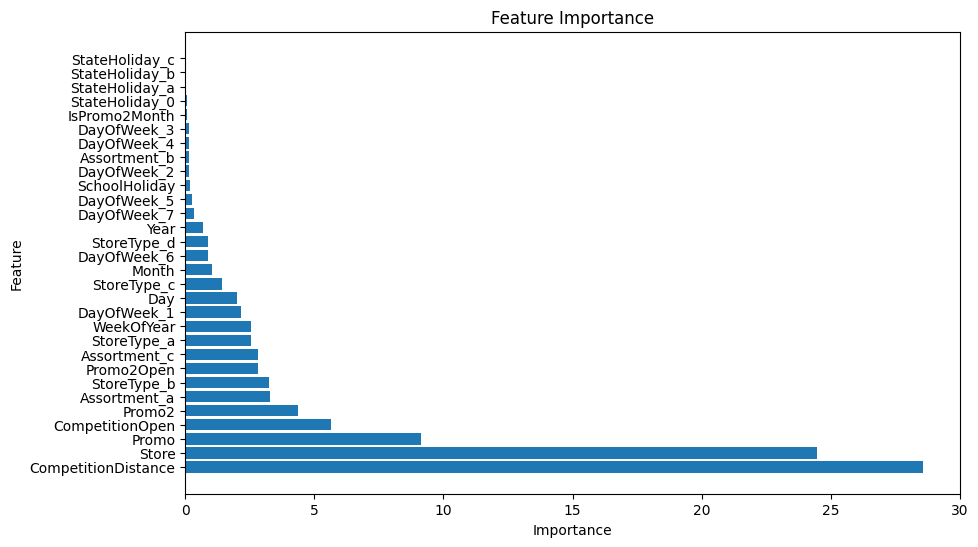

In [34]:
import matplotlib.pyplot as plt
# Get feature names
feature_names = X_train.columns

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances })
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# submission

In [32]:
#  save the test predictions to a CSV file for submission
submission_df['Sales'] = test_predictions
submission_df.to_csv('catboost_submission.csv', index=False)